# Deasang Time serise 

대상 데이터를 활용해 아래와 같은 결과 값을 구현하였습니다.


**목적**

- 각 아이템의 과거 데이터로 2020년도 QTY 예측


**시계열 모델정보**
- _Autom_Arima_
- _Autom_Arima_ 처음 실행시   **!pip install pmdarima** 코드 실행 필요

**Input 정보**
- 데이터 셋 파일명: DAESANG_DATA_prepared.csv
- 설정 옵션 파일명: input_시계열모델_설정옵션.csv
- 분석 조건 값 파일명: input_시계열모델_조건설정값.csv
- 데이터 유형 파일명: input_시계열모델_데이터유형.csv

**Output 정보**
- 예측 결과
- 예측 모델 정보
- 예측 모델 값
- 변수 중요도



※ 자세한 Input정보는 같은 폴더에 있는 Readme를 참고 해주세요.

## 1. 개요

### 시나리오 1. 시계열 분석
- 예측 모델의 입출력 값
  - Input(x)는 QTY의 과거 값
  - Output(y)는 QTY의 미래 예측 값 


In [1]:
# !pip install pmdarima # have to install for Library # 처음 실행시 필요

In [2]:
# 필요 라이브러리
import csv
import pandas as pd
import numpy as np
import ast

from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose 
from pandas import DataFrame
from pandas import read_csv
from pandas import datetime

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA

import pmdarima
from pmdarima import auto_arima


In [3]:
# 구현 함수
def get_data_type(data_type_file):
    data_type_df = pd.read_csv(data_type_file,encoding='cp949')
    
    x_val = data_type_df.loc[data_type_df['Role']=='x', 'col_name'].tolist() # x변수 다중리스트형태
    y_val = data_type_df.loc[data_type_df['Role']=='y', 'col_name'].tolist()[0] # y변수는 단일
    predic_period = data_type_df.loc[data_type_df['예측주기']=='P', 'col_name'].tolist()[0] # y변수는 단일
    
    dummy_list = data_type_df.loc[data_type_df['col_info']=='STR', 'col_name'].tolist()# y변수는 단일
    
    item_col = data_type_df.loc[data_type_df['col_info']=='STR_KEY', 'col_name'].tolist()# y변수는 단일
    
    return x_val, y_val, dummy_list,item_col[0],predic_period

def get_variables(setting_file_name, condition_file_name):
    """
    Input: setting_file_name(모델설정값파일이름), condition_file_name(조건설정값파일이름)
    
    Input 설정 파일에서 지정된 컬럼 명으로 설정 값 및 조건 값들을 불러옴
    
    return: Date지정 컬럼명, 타겟 컬럼명, 주기 값, 조건 값(리스트 )
    """
    setting_df = pd.read_csv(setting_file_name,encoding='cp949')
    date_col_name = setting_df.at[0, 'Date_col'] 
    target_name = setting_df.at[0, 'Target'] 
    p = setting_df.at[0, 'Period'] 
    
    condition_df = pd.read_csv(condition_file_name,encoding='cp949')
    keys = condition_df['condition_col_name'].tolist()
    values = condition_df['condition'].tolist()
    
    condition_list = get_conditions(keys,values)
    
    return date_col_name, target_name, p, condition_list

def change_col_to_int (df, col_name_change_to_int): 
    # 데이터 유형 정보가 담긴 row1이 string이라 계산값 (타겟) int전환 필요
    df[col_name_change_to_int] = df[col_name_change_to_int].astype('int32')

def get_conditions(keys,values):
    """
    Input: keys(조건 컬럼명), values(조건)
    
    return: Dictionary 형태로 조건 컬럼명과 조건 
    """
    values = [tryeval(x) for x in values]
    values2 = [[_] for _ in values]
    conditions = dict(zip(keys, values2))
    return conditions

def tryeval(val): # change str into int in a list 
    try:
        val = ast.literal_eval(val)
    except ValueError:
        pass
    return val

def get_dataset(data_file_name,target_name):
    """
    Input: data_file_name(데이터셋 파일이름),target_name(설정값에서 불러온 타겟명)
    
    파일읽고 df에 저장, 타겟값은 int로 지정, Train dataset, TestDataset 분리
    """
    df = pd.read_csv(data_file_name, encoding='cp949') # encoding은 한국어 load 
    df = df.drop([0]) # 데이터 유형은 실제 데이터 학습에 필요하지 않음으로 드롭
    df.fillna(0, inplace=True) # RD에 있는 NAN 데이터를 0으로 바꿈 => 데이터 유형을 정수로 표현하기 위해 (데이터 셋 분리과정)
    change_col_to_int(df,target_name)
    
    # TD, RD 분리 (학습 데이터 및 실험 데이터 생성)
    train = df[df['DATA_TYPE']== 'TD']
    test = df[df['DATA_TYPE']== 'RD']
    
    return df, train, test

def get_model_var(df,Model_ver):  #모델버전 생성 
    df = df.reset_index(drop=False)
    Model_ver_list =  [Model_ver] * len(df)
    Model_ver_list = pd.DataFrame(Model_ver_list, columns =['모델 버전'])
    
    updated_df = pd.concat([Model_ver_list,df] ,axis=1)
    return updated_df

def c_columns(df):
    cols = []
    cols.append('모델')
    for i in range(len(df.columns)-1):
        col = 'c'+str(i)
        cols.append(col)
    return cols

def export_results(df_model): #시계열 식 결과 export into excel
    model_results = df_model.summary()

    model_info = model_results.tables[0].as_html()
    model_info = pd.read_html(model_info, header=0, index_col=0)[0]
    
    model_result = model_results.tables[1].as_html()
    model_result = pd.read_html(model_result, header=0, index_col=0)[0] # Excel 내보내기
    
    Model_ver = model_info['y'][0] + "_" + model_info['y'][1] + "_"+model_info['y'][2]
   
    model_info_df = get_model_var(model_info,Model_ver)
    model_info_df.columns = pd.MultiIndex.from_tuples(zip(c_columns(model_info_df), model_info_df.columns)) 
    
    model_result_df = get_model_var(model_result,Model_ver)
    model_result_df.columns = pd.MultiIndex.from_tuples(zip(c_columns(model_result_df), model_result_df.columns)) 
    
    return model_info_df,model_result_df,Model_ver

def export_results_reg(df_model,y_pred_year,y_test,f1,f2,f3): #시계열 식 결과 export into excel
    model_results = df_model.summary()

    model_info = model_results.tables[0].as_html()
    model_info = pd.read_html(model_info, header=0, index_col=0)[0]
    
    model_result = model_results.tables[1].as_html()
    model_result = pd.read_html(model_result, header=0, index_col=0)[0] # Excel 내보내기
    
    Model_ver = model_info[y_val][0] + "_" + model_info[y_val][1] + "_"+model_info[y_val][2]
   
    model_info_df = get_model_var(model_info,Model_ver)
    model_info_df.columns = pd.MultiIndex.from_tuples(zip(c_columns(model_info_df), model_info_df.columns)) 
    
    model_result_df = get_model_var(model_result,Model_ver)
    model_result_df.columns = pd.MultiIndex.from_tuples(zip(c_columns(model_result_df), model_result_df.columns)) 
    
    prediction_df = pd.DataFrame(data=y_pred_year)
    prediction_df.columns = ['예측값']
    
    results_pred_df = get_model_var(prediction_df,Model_ver)
    results_pred_df_= results_pred_df.set_index('PART').join(y_test)
    
    outputfile(results_pred_df_,f1) # 예측값 엑셀로 내보내기
    outputfile(model_info_df,f2) # 모델 정보 엑셀로 내보내기
    outputfile(model_result_df,f3) # 모델 식 엑셀로 내보내기
    
    return model_info_df,model_result_df,Model_ver,results_pred_df_

def outputfile(result1,output_file_name): # Export result into excel 
    result1.to_csv(output_file_name,encoding='utf-8-sig')
    print("\n▼ 폴더에서",output_file_name,"파일을 확인하세요")
    
def export_to_excel(df_model,pred_df,f1,f2,f3):
    model_info , model_result, Model_ver= export_results(df_model)
    pred_df_ = get_model_var(pred_df,Model_ver)
    outputfile(pred_df_,f1) # 예측값 엑셀로 내보내기
    outputfile(model_info,f2) # 모델 정보 엑셀로 내보내기
    outputfile(model_result,f3) # 모델 식 엑셀로 내보내기
    
def filter_df(df, filter_values):
    """
    Input: df(데이터셋), filter_values(Dic 형태의 조건 리스트: condition_list)
    
    Filter df by matching targets for multiple columns.
    지정된 조건에 df 필터
    
    return 조건에 맞는 데이터셋 
    """
    if filter_values is None or not filter_values:
        return df
    return df[
        np.logical_and.reduce([
            df[column].isin(target_values) 
            for column, target_values in filter_values.items()
        ])
    ]




def runAutoArima_Prediction(train,test, target_name, date_col_name, condition, p):
    """
    Input: train(학습용 데이터 셋), test(예측용 데이터 셋),
    target_name (예측변수 - 타겟), date_col_name (Time 컬럼
    ) ,
    condition: 조건 리스트, p(예측 주기)
    
    Output = 시계열 모델식, 예측 데이터 셋
    """
    df_train = filter_df(train, condition)
    df_test = filter_df(test, condition)
    
    Q_train = df_train[[target_name,date_col_name]]
    Q_test = df_test[[target_name,date_col_name]]
    
    Q_train[[target_name] ] = Q_train[[target_name]].astype('int32')
    Q_test[[target_name] ] = Q_test[[target_name]].astype('int32')
    
    Q_train = Q_train.set_index(date_col_name)
    Q_test = Q_test.set_index(date_col_name)
    
    n_p = len(df_test) # 데이터에 RD가 없는 경우 확인
    
    if n_p < 0: # If there are RD
        print("예측기간이 정해지지 않았습니다.")
        
    else:
        stepwise_model_series = auto_arima(Q_train,m=p,seasonal = True)
        stepwise_model_series.fit(Q_train)
        future_forecast_ = stepwise_model_series.predict(n_periods= n_p)
        future_forecast_ = pd.DataFrame(future_forecast_,index = Q_test.index,columns=[target_name])
        if len(condition_list) <= 1:
            pd.concat([Q_train,future_forecast_],axis=1).plot(figsize=(20,5))
            prediected_df = pd.concat([Q_train,future_forecast_]) 
        
        df_test[target_name] = future_forecast_[[target_name]].values
        
    return stepwise_model_series, df_test

# 각 아이템 별 시계열 분석
def Prediction_per_item(train,test,item_col,item, target_name, date_col_name, p):
    """
    Input: train(학습용 데이터 셋), test(예측용 데이터 셋), itme_col (아이템 컬럼 리스트), item(아이템 명)
    target_name(Y 데이터 컬럼 명), date_col_name(시계열 컬럼 명), p(예측 주기)
    """
    df_train = train[train[item_col]== item]
    df_test = test[test[item_col]== item]
    
    Q_train = df_train[[target_name,date_col_name]]
    Q_test = df_test[[target_name,date_col_name]]
    
    Q_train[[target_name] ] = Q_train[[target_name]].astype('int32')
    Q_test[[target_name] ] = Q_test[[target_name]].astype('int32')
    
    Q_train = Q_train.set_index(date_col_name)
    Q_test = Q_test.set_index(date_col_name)
    
    n_p = len(df_test) # 데이터에 RD가 없는 경우 확인
    
    if n_p < 0: # If there are RD
        print("예측기간이 정해지지 않았습니다.")
        
    else:
        stepwise_model_series = auto_arima(Q_train,m=p, max_D =1 ,seasonal = True)
        stepwise_model_series.fit(Q_train)
        future_forecast_ = stepwise_model_series.predict(n_periods= n_p)
        future_forecast_ = pd.DataFrame(future_forecast_,index = Q_test.index,columns=[target_name])
        pd.concat([Q_train,future_forecast_],axis=1).plot(figsize=(20,5))
        prediected_df = pd.concat([Q_train,future_forecast_]) 
        print('아이템 컬럼: ',item_col,", 아이템 명: ",item)
        print(prediected_df)
        
    return prediected_df,stepwise_model_series



## 2.  데이터 불러오기 및 데이터 준비  (공통)
#### 2.1 설정 값 파일 읽기 (사용 된 함수)
   - get_variables() : 날자 컬럼, 타겟 컬럼, 주기, 조건 리스트
   -  get_dataset()  : Train & Test 데이터 세트 준비
   - get_data_type() : x변수, y변수, 명목변수, key이름, 주기 준비

In [4]:
# Input 파일 
data_file_name = 'DAESANG_DATA_prepared.csv'
setting_file_name = 'input_시계열모델_설정옵션.csv'
data_type_file = 'input_시계열모델_데이터유형.csv'
condition_file_name = 'input_시계열모델_조건설정값.csv'

## 시나리오 1. 시계열 분석
runAutoArima_Prediction(): Auto Arima 실행 
   - 조건별 RD 예측
       - 시나리오 1.1 아이템별 y값 예측
       - 시나리오 1.2 Feature 조건별 y값 예측
       
       
Output▶ 예측값 및 모델 정보 출력


In [5]:
date_col_name, target_name, p, condition_list = get_variables(setting_file_name, condition_file_name)
df, train, test = get_dataset(data_file_name,target_name) #df: raw data, train:TD test:RD
x_val, y_val, dummy_list,item_col,predic_period = get_data_type(data_type_file) # x변수, y변수, 명목변수, key이름, 주기

C:\Users\Kstec\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (2,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


### 시나리오 1.1 아이템 별 y 값 예측

C:\Users\Kstec\anaconda3\lib\site-packages\pandas\core\frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-3-49e25d352a49>:203: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  pd.concat([Q_train,future_forecast_],axis=1).plot(figsize=(20,5))
C:\Users\Kstec\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
<ipython-input-3-49e25d352a49>:206: SettingWithCopyWarning: 
A

,PRJ_ID,DATA_TYPE,PART,MONTH_NO,MONTH,YEAR,QTY,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5
65640,DAESANG,RD,1019260,20-Jan,Jan,20,873.591184,냉동,B2C,222220100,X,A
65641,DAESANG,RD,1019260,20-Feb,Feb,20,963.527897,냉동,B2C,222220100,X,A
65642,DAESANG,RD,1019260,20-Mar,Mar,20,1015.850495,냉동,B2C,222220100,X,A
65643,DAESANG,RD,1019260,20-Apr,Apr,20,1046.290280,냉동,B2C,222220100,X,A
65644,DAESANG,RD,1019260,20-May,May,20,1063.999273,냉동,B2C,222220100,X,A


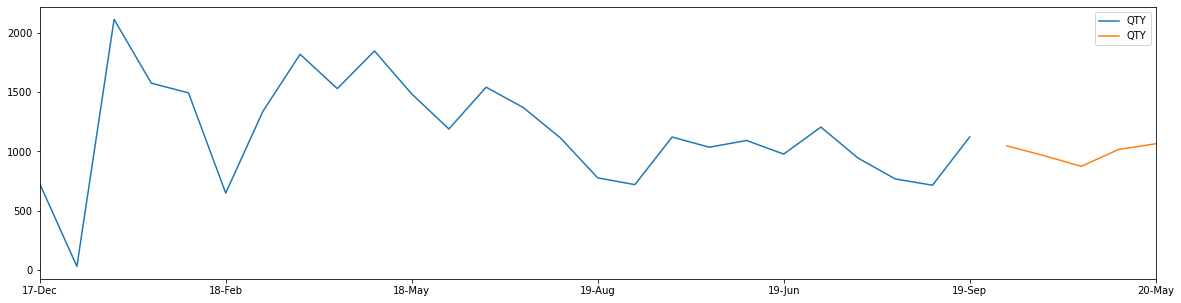

In [6]:
# PART: 1019260 예측
df_model, pred_df = runAutoArima_Prediction(train,test, target_name, date_col_name, condition_list, p)
pred_df

In [7]:
file_name_1 = "output_시계열모델_예측결과.csv" # 예측값 엑셀로 내보내기
file_name_2 = "output_시계열모델_정보.csv"     # 모델 정보 엑셀로 내보내기
file_name_3 = "output_시계열모델_결과.csv"     # 모델 식 엑셀로 내보내기
# 결과 엑셀로 내보내기
export_to_excel(df_model,pred_df, file_name_1,file_name_2,file_name_3) # 예측값,모델 정보, 모델 식 


▼ 폴더에서 output_시계열모델_예측결과.csv 파일을 확인하세요

▼ 폴더에서 output_시계열모델_정보.csv 파일을 확인하세요

▼ 폴더에서 output_시계열모델_결과.csv 파일을 확인하세요


### 시나리오 1.2  조건별 y값 예측
- 조건: 3월 냉동식품 B2C A급

In [8]:
condition_file_name = 'input_시계열모델_조건설정값2.csv' 
date_col_name, target_name, p, condition_list = get_variables(setting_file_name, condition_file_name)
df, train, test = get_dataset(data_file_name,target_name)
train_month = filter_df(train, condition_list)
test_month = filter_df(test, condition_list)

C:\Users\Kstec\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (2,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [9]:
df_model, pred_df = runAutoArima_Prediction(train_month,test_month,target_name, date_col_name, condition_list, p)
pred_df

C:\Users\Kstec\anaconda3\lib\site-packages\pandas\core\frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,PRJ_ID,DATA_TYPE,PART,MONTH_NO,MONTH,YEAR,QTY,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5
65642,DAESANG,RD,1019260,20-Mar,Mar,20,982.283191,냉동,B2C,222220100,X,A
65698,DAESANG,RD,1019746,20-Mar,Mar,20,1415.812175,냉동,B2C,222220100,X,A
65723,DAESANG,RD,1019747,20-Mar,Mar,20,1614.849266,냉동,B2C,222220100,X,A
65814,DAESANG,RD,1020019,20-Mar,Mar,20,1706.229002,냉동,B2C,222220100,X,A
65835,DAESANG,RD,1020111,20-Mar,Mar,20,1748.182268,냉동,B2C,222220100,X,A
71544,DAESANG,RD,1021511,20-Mar,Mar,20,1767.443393,냉동,B2C,222220100,X,A
78489,DAESANG,RD,1103663,20-Mar,Mar,20,1776.286350,냉동,B2C,222140100,X,A
78985,DAESANG,RD,1103666,20-Mar,Mar,20,1780.346232,냉동,B2C,222140120,X,A
79059,DAESANG,RD,1103671,20-Mar,Mar,20,1782.210161,냉동,B2C,222140120,X,A
79096,DAESANG,RD,1103674,20-Mar,Mar,20,1783.065908,냉동,B2C,222140120,X,A


In [10]:
file_name_1 = "output_시계열모델_A급냉동3월_예측결과.csv" # 예측값 엑셀로 내보내기
file_name_2 = "output_시계열모델_A급냉동3월_정보.csv"     # 모델 정보 엑셀로 내보내기
file_name_3 = "output_시계열모델_A급냉동3월_결과.csv"     # 모델 식 엑셀로 내보내기
# 결과 엑셀로 내보내기
export_to_excel(df_model,pred_df, file_name_1,file_name_2,file_name_3) # 예측값,모델 정보, 모델 식 


▼ 폴더에서 output_시계열모델_A급냉동3월_예측결과.csv 파일을 확인하세요

▼ 폴더에서 output_시계열모델_A급냉동3월_정보.csv 파일을 확인하세요

▼ 폴더에서 output_시계열모델_A급냉동3월_결과.csv 파일을 확인하세요
